<a href="https://colab.research.google.com/github/TejNihash/Temperature_prediction/blob/main/time_series_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Temperature of banglore

In [ ]:
%cd '/content/drive/MyDrive/data science practice/banglore_weather'

/content/drive/MyDrive/data science practice/banglore_weather


# Import the libraries




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import  ExponentialSmoothing
import numpy as np
from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor


from statsmodels.tsa.statespace.sarimax import SARIMAX


# Useful functions


In [ ]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [ ]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.xticks(rotation = 45)
  plt.legend()
  plt.show()

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=45,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [ ]:
df = pd.read_csv('bengaluru_temp_hourly_data.csv')

In [ ]:
df.head()

,latitude,longitude,elevation,utc_offset_seconds,timezone,timezone_abbreviation
0,12.970123,77.56364,918.0,28800.0,Asia/Singapore,GMT+8
1,time,temperature_2m (°C),NaN,NaN,NaN,NaN
2,2011-01-28T00:00,19.2,NaN,NaN,NaN,NaN
3,2011-01-28T01:00,18.1,NaN,NaN,NaN,NaN
4,2011-01-28T02:00,17.1,NaN,NaN,NaN,NaN


We see that first row is some meta data and 2nd row is the titles. So, let's reframe them.

In [ ]:
# Skip metadata row (index 0), and load only relevant columns
df = pd.read_csv("bengaluru_temp_hourly_data.csv", skiprows=2, usecols=["time", "temperature_2m (°C)"])


# Parse datetime and set time as index
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)

In [ ]:
df.head()

,temperature_2m (°C)
time,
2011-01-28 00:00:00,19.2
2011-01-28 01:00:00,18.1
2011-01-28 02:00:00,17.1
2011-01-28 03:00:00,16.3
2011-01-28 04:00:00,15.3


In [ ]:
#let's check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126720 entries, 2011-01-28 00:00:00 to 2025-07-12 23:00:00
Data columns (total 1 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   temperature_2m (°C)  126720 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


Null values - null

great

Let's get the tavg, tmin and tmax

In [ ]:
daily = pd.DataFrame()
daily["tavg"] = df["temperature_2m (°C)"].resample("D").mean()
daily["tmin"] = df["temperature_2m (°C)"].resample("D").min()
daily["tmax"] = df["temperature_2m (°C)"].resample("D").max()

In [ ]:
daily.head()

,tavg,tmin,tmax
time,,,
2011-01-28,20.075000,11.9,28.4
2011-01-29,20.795833,13.8,28.2
2011-01-30,20.575000,13.5,28.1
2011-01-31,21.029167,13.8,28.6
2011-02-01,21.025000,14.4,28.4


In [ ]:
daily['rolling_avg'] = daily['tavg'].rolling(window = 7,min_periods = 5).mean()

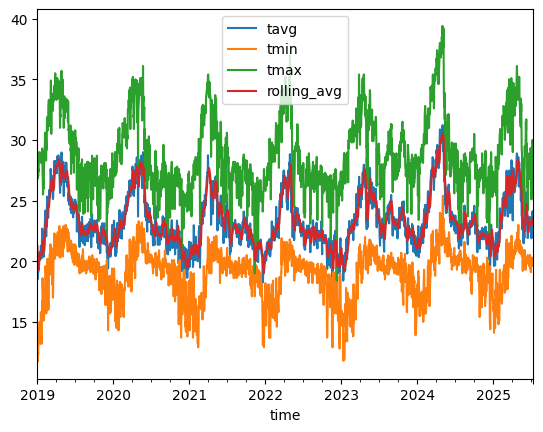

In [ ]:
daily['2019':].plot()
plt.show()

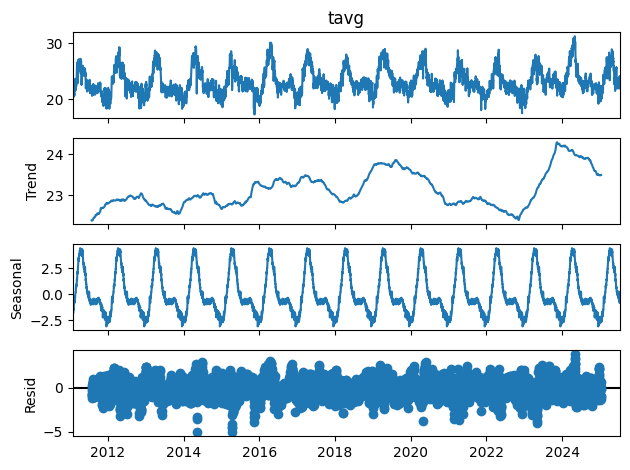

In [ ]:
# Making the decompose plot to visualize trend, seasonality and residuals

decomp = seasonal_decompose(daily['tavg'],period = 365)

decomp.plot()
plt.show()



Insights time:

So there  is a trend which goes up and down, so,models would struggle with that a bit. But since the differnce isn't much, the error would likely be around 1 to 2 degrees which isn't bad for general forecasting purposes

We can see seasonality in the original data pretty well, which means, we can make some fairly good models for forecasting

/tmp/ipython-input-18-1698515442.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(daily['tavg'].resample('Q').mean())


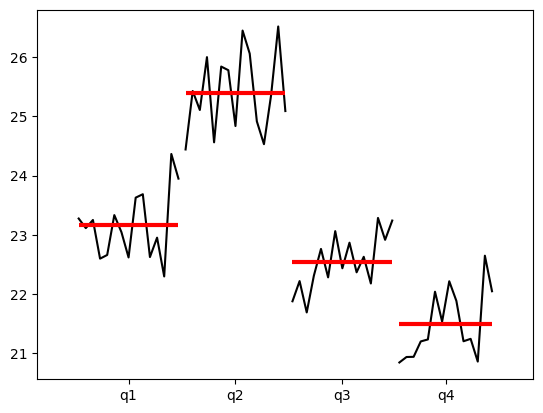

In [ ]:
# let's look at monthly and quarterly to see if there is anything noticeable
quarter_plot(daily['tavg'].resample('Q').mean())
plt.show()

So , we can notice that there is a difference between each quarter and hence seasons, and within a quarter, we see ups and downs cause there isn't a clear up or down trend.:

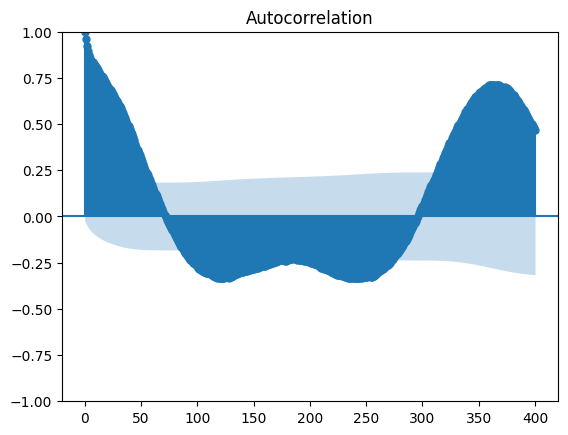

In [ ]:
plot_acf(daily['tavg'],lags = 400)
plt.show()

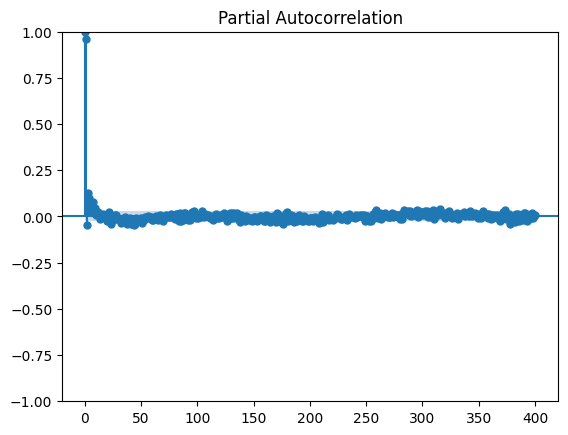

In [ ]:
plot_pacf(daily['tavg'],lags = 400)
plt.show()

So here, auto correlation shows the seasonality of the data, which looks like it repeats itself every 365 time steps.

And partial auto correlation shows that lag 1 value explains the current data well.And considering the fact that trend isn't smooth, the data might have a good cyclic behaviour.

So, based on that, holt winters won't be a good model to forecast.
we can observer better forecasting by sarimax. But the thing with it is, it will take long time to train it with a seasonal period of 365.

Let's split the data

In [ ]:
period = 90 # for 90 days forecasting

train, test = daily['tavg'].iloc[:-period], daily['tavg'].iloc[-period:]

In [ ]:
holt_model = ExponentialSmoothing(train,seasonal= 'add',trend = 'add',seasonal_periods = 365).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
holt_preds = holt_model.forecast(len(test))

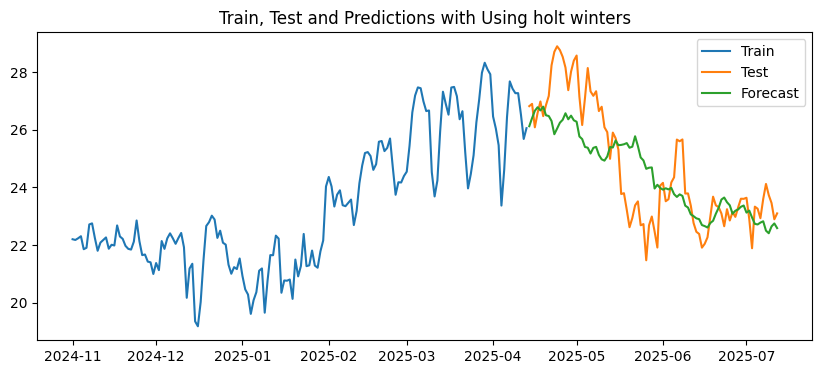

The MAE is 1.09
The RMSE is 1.39
The MAPE is 4.37 %


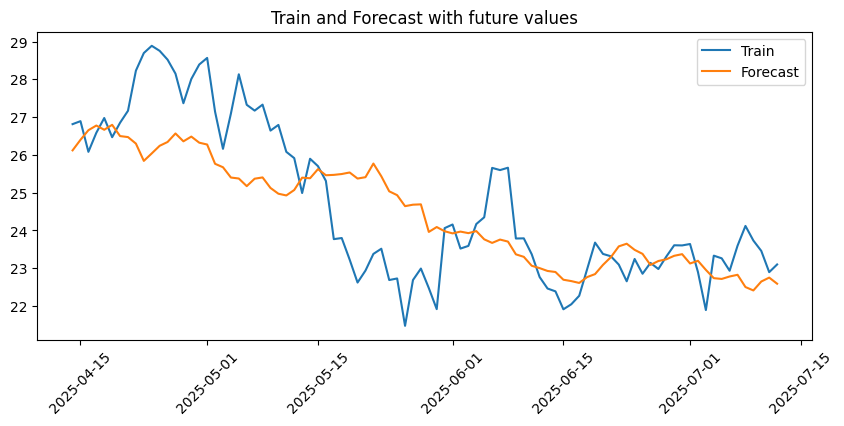

In [ ]:
model_assessment(train['2024-11':],test,holt_preds,'Using holt winters')
plot_future(test,holt_preds,'future values')

So using holt winters , we got the above model, for a forecasting period of 90 days.
Mean absolute error is 1.09 which means, on average it's wrong by that much.
RMSE which penalizes large differences is about 1.39, so we can say that the models is forecasting quite well.


# Holt winters model


In [ ]:
final_hw_model = ExponentialSmoothing(daily['tavg'],seasonal= 'add',trend = 'add',seasonal_periods = 365).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
holt_forecasts = final_hw_model.forecast(90)

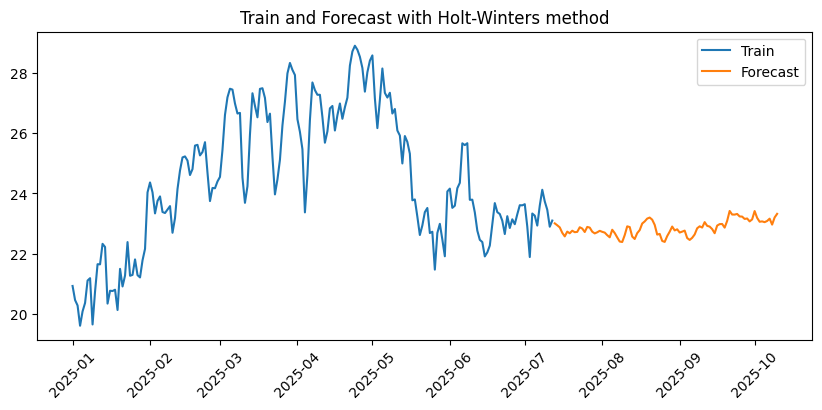

In [ ]:
plot_future(daily['tavg']['2025':],holt_forecasts,'Holt-Winters method')

In [ ]:
holt_forecasts # to get an actual look at the data

,0
2025-07-13,23.007085
2025-07-14,22.943439
2025-07-15,22.873666
2025-07-16,22.694522
2025-07-17,22.575753
...,...
2025-10-06,23.086294
2025-10-07,23.162573
2025-10-08,22.966274
2025-10-09,23.202595


# Lets apply ML models too. Linear regression plus xgboost.

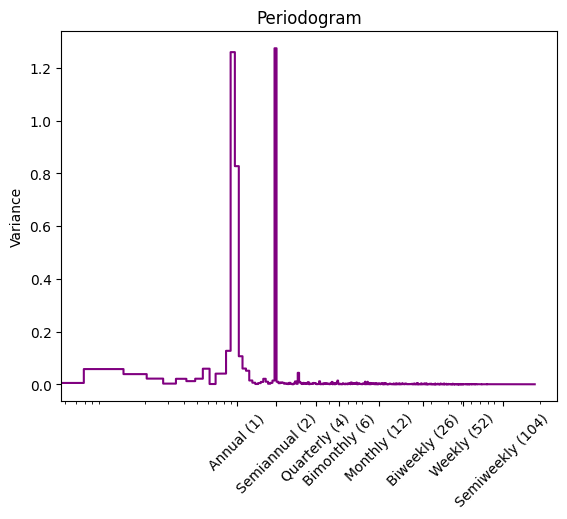

In [ ]:
plot_periodogram(daily['tavg'])
plt.show()

from the plot we can see that yearly and semi anually seasonality is strong. So we gotta have fourier terms with that freq.


In [ ]:
#Just fitting a trend line

dp = DeterministicProcess(
    index = daily.index,
    constant = True,
    order = 3,
    seasonal = False,
)

X = dp.in_sample()

In [ ]:
# so use X as features and Y as the daily['tavg'] and train a linear regressor

linear_model = LinearRegression(fit_intercept=False)

linear_model.fit(X,daily['tavg'])

y_preds = pd.Series(linear_model.predict(X),index = X.index)



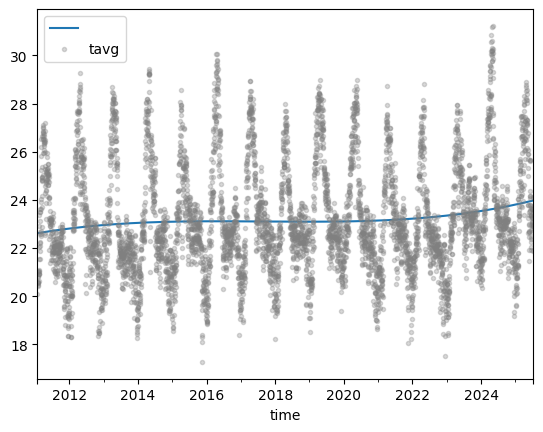

In [ ]:
y_preds.plot(legend = 'linear preds')
daily['tavg'].plot(legend = 'actual',color = '0.5',style = '.',alpha = 0.3)
plt.show()

Now, let's fit seasonality

In [ ]:

fourier = CalendarFourier(freq = 'A',order = 10) # Taking 10 harmonics

dp = DeterministicProcess(
    index = daily.index,
    constant = True,
    order = 3, #let's not go beyond that. Things go bad real quick if we do
    additional_terms = [fourier],
    seasonal = False,
)

X = dp.in_sample()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


In [ ]:
# so use X as features and Y as the daily['tavg'] and train a linear regressor

linear_model = LinearRegression(fit_intercept=False)

linear_model.fit(X,daily['tavg'])

y_preds = pd.Series(linear_model.predict(X),index = X.index)



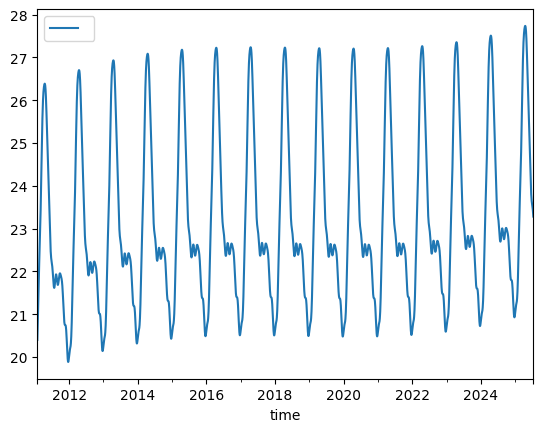

In [ ]:
y_preds.plot(legend = 'linear preds')

#daily['tavg'].plot(legend = 'actual',style = '.',alpha = 0.3)
plt.show()

In [ ]:
X[:len(train)].shape

(5190, 24)

# Linear regression with trend and seasonality

In [ ]:
# lets do a little train and test. see how it is actually working


# so use X as features and Y as the daily['tavg'] and train a linear regressor

X_train = X.iloc[:-period]
y_train = daily['tavg'].iloc[:-period]

X_test = X.iloc[-period:]
y_test = daily['tavg'].iloc[-period:]


linear_model = LinearRegression(fit_intercept=False)

linear_model.fit(X_train,y_train)

y_preds = pd.Series(linear_model.predict(X_test),index = X_test.index)


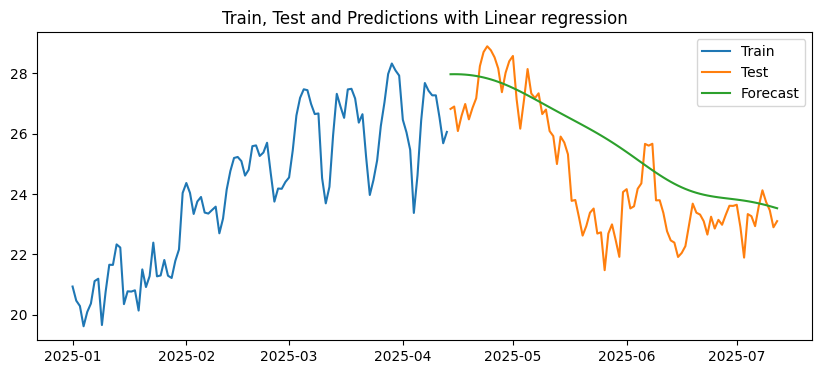

The MAE is 1.24
The RMSE is 1.58
The MAPE is 5.23 %


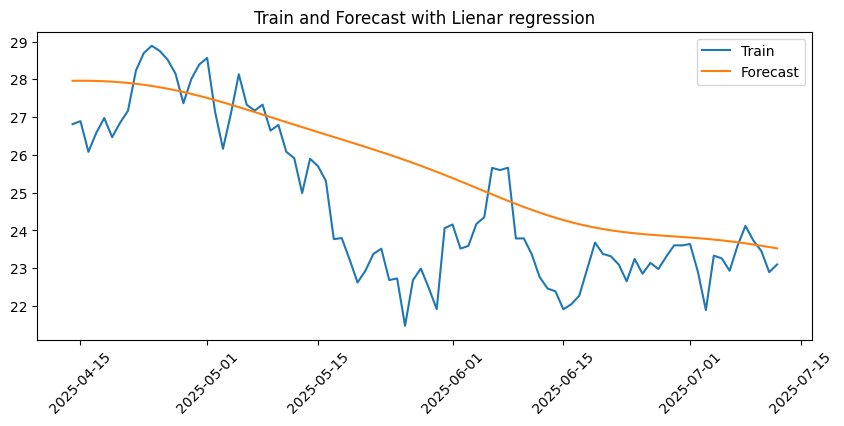

In [ ]:
model_assessment(train['2025':],y_test,y_preds,'Linear regression')
plot_future(y_test,y_preds,'Lienar regression')

Holt winters:

The MAE is 1.09

The RMSE is 1.39

The MAPE is 4.37 %

Simple linear regression:

The MAE is 1.24

The RMSE is 1.58

The MAPE is 5.23 %

So, holt winters is still the champ. How do we make a better ml model?


Let's do a little investigation. We have a linear model that captures the trend and seasonality. Now, let's see what's left.

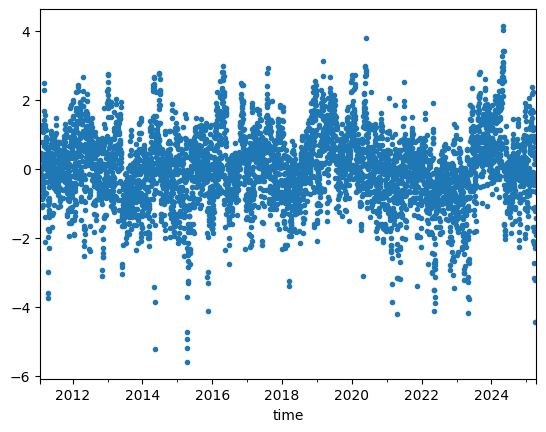

In [ ]:
residuals = y_train-pd.Series(linear_model.predict(X_train),index = X_train.index)

residuals.plot(style = '.')
plt.show()

We can see that, the residuals doesn't really seem quite random. It looks like we could fit a line through it.

But just cause we could fit a line doesn't mean there is a repeating pattern. It could just be cycles which repeat whenever they like and only way to capture them is by using lag features

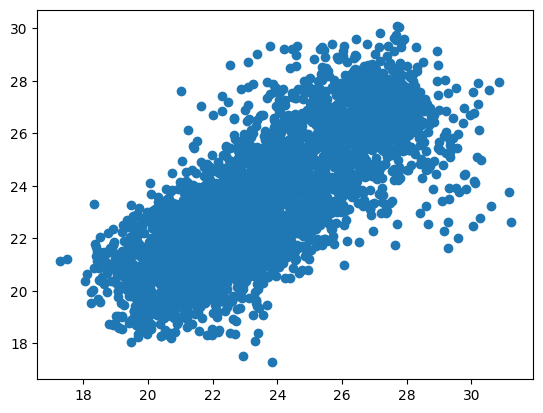

In [ ]:
plt.scatter(y_train,y_train.shift(365))
plt.show()

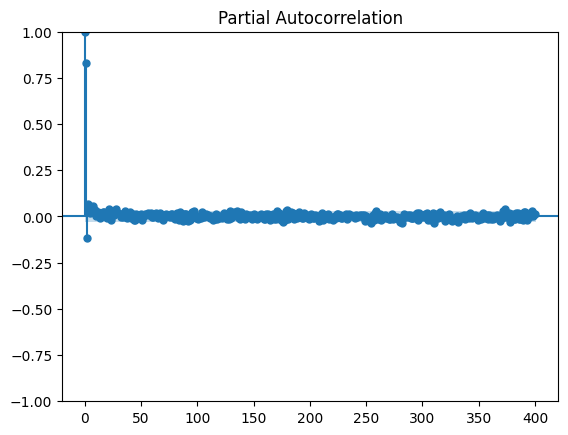

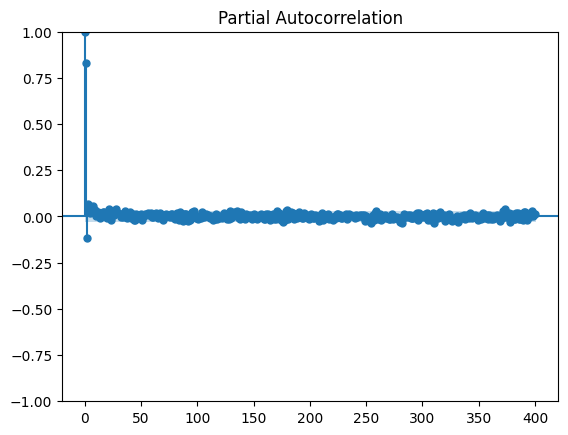

In [ ]:
plot_pacf(residuals,lags  = 400)

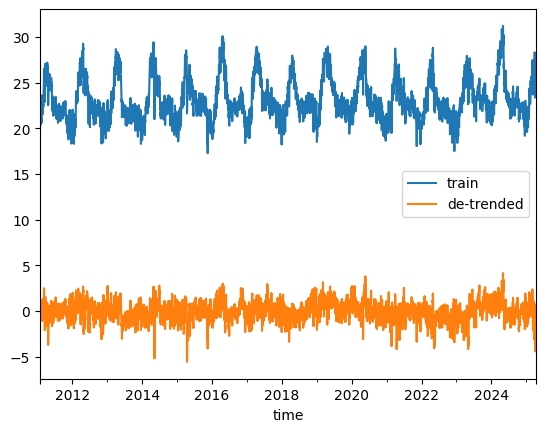

In [ ]:
#Let's take a look at the de-trended data.

de_trended = y_train - pd.Series(linear_model.predict(X_train),index = X_train.index)

y_train.plot(label = 'train')

de_trended.plot(label = 'de-trended')
plt.legend()
plt.show()

# XGB on residuals of linear regression

In [ ]:

xgb_model = XGBRegressor()
xgb_model.fit(X_train,residuals)

y_final_preds = y_preds + pd.Series(xgb_model.predict(X_test),index = X_test.index)






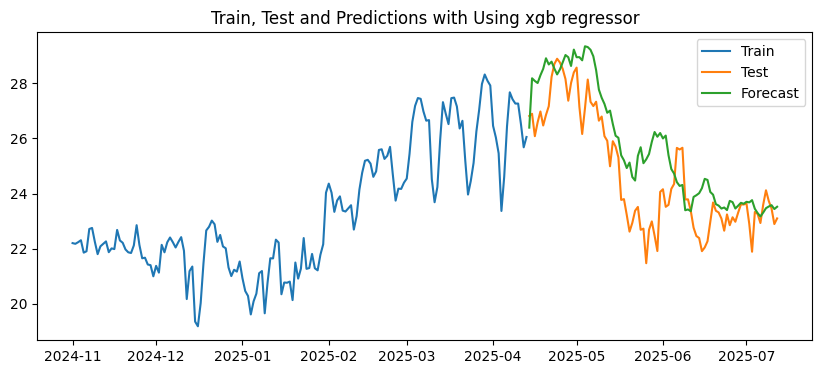

The MAE is 1.21
The RMSE is 1.54
The MAPE is 5.02 %


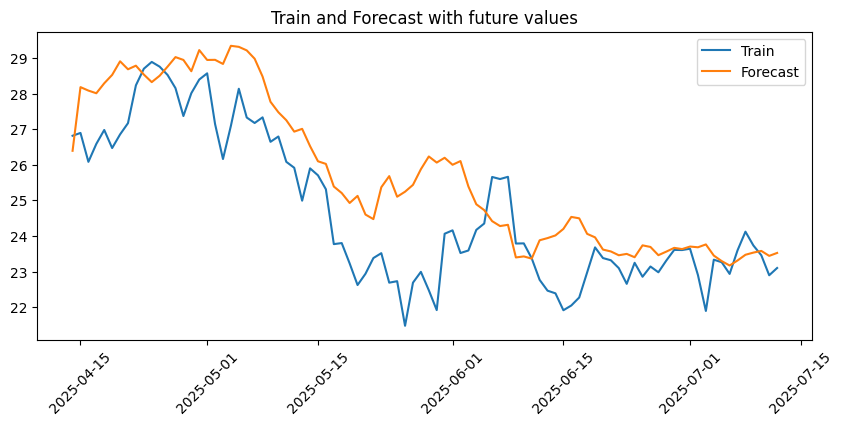

In [ ]:
model_assessment(train['2024-11':],y_test,y_final_preds,'Using xgb regressor')
plot_future(y_test,y_final_preds,'future values')


Alright, so even when we fit the xgboost on the residuals, the error didn't change much. It's likely cause, the model couldn't capture the residuals properly cause they are just random.

We still got one more thing in our arsenal. Lags

Let's use few lags, 4 of them to fit the model better and the use DiRec method to forecast.


In [ ]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [ ]:
X_train_lags = make_lags(y_train,20).dropna()
X_train_lags.tail()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,y_lag_11,y_lag_12,y_lag_13,y_lag_14,y_lag_15,y_lag_16,y_lag_17,y_lag_18,y_lag_19,y_lag_20
time,,,,,,,,,,,,,,,,,,,,
2025-04-09,27.420833,27.675000,26.433333,24.616667,23.370833,25.462500,26.037500,26.458333,27.920833,28.091667,28.320833,27.975000,27.037500,26.250000,25.112500,24.4625,23.966667,25.216667,26.641667,26.362500
2025-04-10,27.266667,27.420833,27.675000,26.433333,24.616667,23.370833,25.462500,26.037500,26.458333,27.920833,28.091667,28.320833,27.975000,27.037500,26.250000,25.1125,24.462500,23.966667,25.216667,26.641667
2025-04-11,27.266667,27.266667,27.420833,27.675000,26.433333,24.616667,23.370833,25.462500,26.037500,26.458333,27.920833,28.091667,28.320833,27.975000,27.037500,26.2500,25.112500,24.462500,23.966667,25.216667
2025-04-12,26.529167,27.266667,27.266667,27.420833,27.675000,26.433333,24.616667,23.370833,25.462500,26.037500,26.458333,27.920833,28.091667,28.320833,27.975000,27.0375,26.250000,25.112500,24.462500,23.966667
2025-04-13,25.679167,26.529167,27.266667,27.266667,27.420833,27.675000,26.433333,24.616667,23.370833,25.462500,26.037500,26.458333,27.920833,28.091667,28.320833,27.9750,27.037500,26.250000,25.112500,24.462500


In [ ]:
X_train  = pd.concat([X_train,X_train_lags],axis = 1).dropna()

#X_train.head()

In [ ]:
X_to_pred = X_train.iloc[[-1]]

In [ ]:
X_to_pred

,const,trend,trend_squared,trend_cubed,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)",...,y_lag_11,y_lag_12,y_lag_13,y_lag_14,y_lag_15,y_lag_16,y_lag_17,y_lag_18,y_lag_19,y_lag_20
time,,,,,,,,,,,,,,,,,,,,,
2025-04-13,1.0,5190.0,26936100.0,1.397984e+11,0.982927,-0.183998,-0.361714,-0.932289,-0.849817,0.527078,...,26.0375,26.458333,27.920833,28.091667,28.320833,27.975,27.0375,26.25,25.1125,24.4625


In [ ]:
y_train_all = make_multistep_target(y_train,90).dropna()

In [ ]:
X_train.tail()

,const,trend,trend_squared,trend_cubed,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)",...,y_lag_11,y_lag_12,y_lag_13,y_lag_14,y_lag_15,y_lag_16,y_lag_17,y_lag_18,y_lag_19,y_lag_20
time,,,,,,,,,,,,,,,,,,,,,
2025-04-09,1.0,5186.0,26894596.0,1.394754e+11,0.993257,-0.115935,-0.230306,-0.973118,-0.939856,0.341571,...,28.320833,27.975000,27.037500,26.250000,25.112500,24.4625,23.966667,25.216667,26.641667,26.362500
2025-04-10,1.0,5187.0,26904969.0,1.395561e+11,0.991114,-0.133015,-0.263665,-0.964614,-0.920971,0.389630,...,28.091667,28.320833,27.975000,27.037500,26.250000,25.1125,24.462500,23.966667,25.216667,26.641667
2025-04-11,1.0,5188.0,26915344.0,1.396368e+11,0.988678,-0.150055,-0.296713,-0.954967,-0.899631,0.436651,...,27.920833,28.091667,28.320833,27.975000,27.037500,26.2500,25.112500,24.462500,23.966667,25.216667
2025-04-12,1.0,5189.0,26925721.0,1.397176e+11,0.985948,-0.167052,-0.329408,-0.944188,-0.875892,0.482508,...,26.458333,27.920833,28.091667,28.320833,27.975000,27.0375,26.250000,25.112500,24.462500,23.966667
2025-04-13,1.0,5190.0,26936100.0,1.397984e+11,0.982927,-0.183998,-0.361714,-0.932289,-0.849817,0.527078,...,26.037500,26.458333,27.920833,28.091667,28.320833,27.9750,27.037500,26.250000,25.112500,24.462500


In [ ]:
y_train_all.tail()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,...,y_step_81,y_step_82,y_step_83,y_step_84,y_step_85,y_step_86,y_step_87,y_step_88,y_step_89,y_step_90
time,,,,,,,,,,,,,,,,,,,,,
2025-01-10,20.754167,21.654167,21.650000,22.329167,22.225000,20.350000,20.775000,20.766667,20.808333,20.137500,...,27.920833,26.458333,26.037500,25.462500,23.370833,24.616667,26.433333,27.675000,27.420833,27.266667
2025-01-11,21.654167,21.650000,22.329167,22.225000,20.350000,20.775000,20.766667,20.808333,20.137500,21.500000,...,26.458333,26.037500,25.462500,23.370833,24.616667,26.433333,27.675000,27.420833,27.266667,27.266667
2025-01-12,21.650000,22.329167,22.225000,20.350000,20.775000,20.766667,20.808333,20.137500,21.500000,20.916667,...,26.037500,25.462500,23.370833,24.616667,26.433333,27.675000,27.420833,27.266667,27.266667,26.529167
2025-01-13,22.329167,22.225000,20.350000,20.775000,20.766667,20.808333,20.137500,21.500000,20.916667,21.279167,...,25.462500,23.370833,24.616667,26.433333,27.675000,27.420833,27.266667,27.266667,26.529167,25.679167
2025-01-14,22.225000,20.350000,20.775000,20.766667,20.808333,20.137500,21.500000,20.916667,21.279167,22.387500,...,23.370833,24.616667,26.433333,27.675000,27.420833,27.266667,27.266667,26.529167,25.679167,26.054167


In [ ]:
y_train_all, X_train = y_train_all.align(X_train, join='inner', axis=0)

In [ ]:
from xgboost import XGBRegressor
from sklearn.multioutput import RegressorChain


In [ ]:
Xgb_model = RegressorChain(XGBRegressor())


In [ ]:
daily['tavg'].head()

,tavg
time,
2011-01-28,20.075000
2011-01-29,20.795833
2011-01-30,20.575000
2011-01-31,21.029167
2011-02-01,21.025000


In [ ]:
y_train_all.tail()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,...,y_step_81,y_step_82,y_step_83,y_step_84,y_step_85,y_step_86,y_step_87,y_step_88,y_step_89,y_step_90
time,,,,,,,,,,,,,,,,,,,,,
2025-01-10,20.754167,21.654167,21.650000,22.329167,22.225000,20.350000,20.775000,20.766667,20.808333,20.137500,...,27.920833,26.458333,26.037500,25.462500,23.370833,24.616667,26.433333,27.675000,27.420833,27.266667
2025-01-11,21.654167,21.650000,22.329167,22.225000,20.350000,20.775000,20.766667,20.808333,20.137500,21.500000,...,26.458333,26.037500,25.462500,23.370833,24.616667,26.433333,27.675000,27.420833,27.266667,27.266667
2025-01-12,21.650000,22.329167,22.225000,20.350000,20.775000,20.766667,20.808333,20.137500,21.500000,20.916667,...,26.037500,25.462500,23.370833,24.616667,26.433333,27.675000,27.420833,27.266667,27.266667,26.529167
2025-01-13,22.329167,22.225000,20.350000,20.775000,20.766667,20.808333,20.137500,21.500000,20.916667,21.279167,...,25.462500,23.370833,24.616667,26.433333,27.675000,27.420833,27.266667,27.266667,26.529167,25.679167
2025-01-14,22.225000,20.350000,20.775000,20.766667,20.808333,20.137500,21.500000,20.916667,21.279167,22.387500,...,23.370833,24.616667,26.433333,27.675000,27.420833,27.266667,27.266667,26.529167,25.679167,26.054167


In [ ]:
Xgb_model.fit(X_train, y_train_all)



RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...))

We don't actually have to make a split into train and test here. Just use the whole thing.

In [ ]:
'''X_train = X[:len(train)]
y_train = daily['tavg'][:len(train)]

X_test = X[len(train):]
y_test = daily['tavg'][len(train):]

X_train_lags = make_lags(y_train,10).dropna()

X_train  = pd.concat([X_train,X_train_lags],axis = 1).dropna()



y_train_all = make_multistep_target(y_train,90).dropna()

y_train_all, X_train = y_train_all.align(X_train, join='inner', axis=0)

X_last = X_train.tail(1)'''

In [ ]:
y_pred = Xgb_model.predict(X_to_pred)


In [ ]:


# Get forecast horizon (e.g. 90)
horizon = y_pred.shape[1]

# Optional: get starting point for forecast index
start_date = y_test.index[0]  # or y_train.index[-period] if you're matching against real values

# If your data is datetime-indexed (e.g. daily):
index = pd.date_range(start=start_date + pd.Timedelta(days=1), periods=horizon, freq="D")

# Create the DataFrame
y_pred_df = pd.DataFrame(y_pred.T, index=index, columns=["forecast"])


In [ ]:
y_test

,tavg
time,
2025-04-14,26.816667
2025-04-15,26.895833
2025-04-16,26.083333
2025-04-17,26.587500
2025-04-18,26.979167
...,...
2025-07-08,24.120833
2025-07-09,23.733333
2025-07-10,23.458333


In [ ]:
y_pred_df

,forecast
2025-04-15,23.681652
2025-04-16,23.699905
2025-04-17,24.691462
2025-04-18,24.854872
2025-04-19,24.444643
...,...
2025-07-09,23.073523
2025-07-10,22.667664
2025-07-11,22.208603
2025-07-12,22.134737


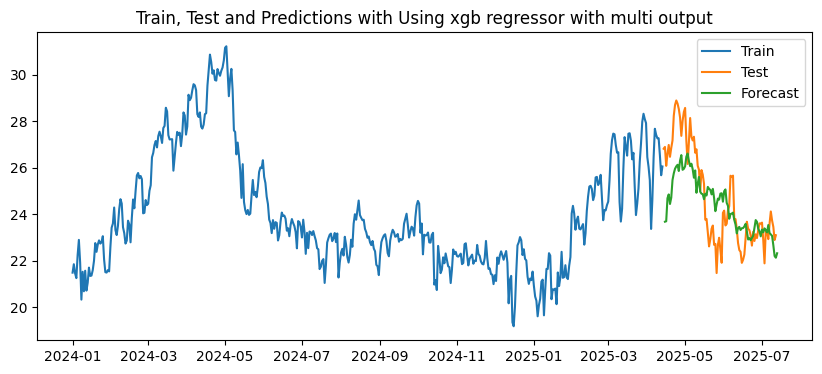

The MAE is 1.24
The RMSE is 1.48
The MAPE is 4.96 %


In [ ]:
model_assessment(train['2024':],y_test,y_pred_df,'Using xgb regressor with multi output')


So, We can see that, xgboost with multiple output isn't doing any better than holtwinters.
So we are going to use holtwinters finally.

# Holt winters win

In [ ]:
X_train = X
y_train = daily['tavg']

X_test = X[len(train):]
y_test = daily['tavg'][len(train):]

lags_period = 10
horizon = 90

X_train_lags = make_lags(y_train,lags_period).dropna()

X_train  = pd.concat([X_train,X_train_lags],axis = 1).dropna()



y_train_all = make_multistep_target(y_train,horizon).dropna() # so here , the last 90 data points are going to get dropped

y_train_all, X_train = y_train_all.align(X_train, join='inner', axis=0) # they all get to align.

X_last = X_train.tail(1) # this is the last but 90th term. Use it to get the predictions that relate to test data

# XGB with multioutput and lags

In [ ]:
model = RegressorChain(XGBRegressor())
model.fit(X_train, y_train_all)

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...))

In [ ]:
y_pred = model.predict(X_last)


In [ ]:

# Get forecast horizon (e.g. 90)
horizon = y_pred.shape[1]

# Optional: get starting point for forecast index
start_date = y_train.index[-(period+1)]  # or y_train.index[-period] if you're matching against real values

# If your data is datetime-indexed (e.g. daily):
index = pd.date_range(start=start_date + pd.Timedelta(days=1), periods=horizon, freq="D")

# Create the DataFrame
y_pred_df = pd.DataFrame(y_pred.T, index=index, columns=["model_preds"])


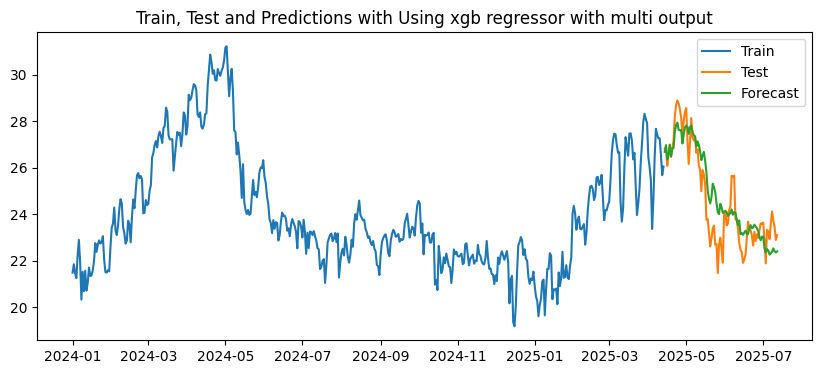

The MAE is 0.79
The RMSE is 1.00
The MAPE is 3.28 %


In [ ]:
model_assessment(train['2024':],y_train[-period:],y_pred_df,'Using xgb regressor with multi output')


HOlt winter results:

The MAE is 1.09

The RMSE is 1.39

The MAPE is 4.37 %



Let's predict the next 90 days

In [ ]:
X_last = X.tail(1)

In [ ]:
# 1. Get the last known row of external features
X_last = X.iloc[[-1]].copy()  # make sure it's a DataFrame

# 2. Get the latest `lags_period` values from daily['tavg']
latest_lags = daily['tavg'].iloc[-lags_period:]      # shape = (lags_period,)
latest_lags = latest_lags[::-1].reset_index(drop=True)  # reverse to lag_1, lag_2, ..., lag_n

# 3. Create a DataFrame for lags
lags_df = pd.DataFrame([latest_lags.values],
                       columns=[f"y_lag_{i}" for i in range(1, lags_period + 1)],
                       index=X_last.index)

# 4. Concatenate X and lag features into a single row
X_last_last = pd.concat([X_last, lags_df], axis=1)


,const,trend,trend_squared,trend_cubed,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)",...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
time,,,,,,,,,,,,,,,,,,,,,
2025-07-12,1.0,5280.0,27878400.0,1.471980e+11,-0.162807,-0.986658,0.32127,0.946988,-0.47116,-0.882048,...,23.1,22.895833,23.458333,23.733333,24.120833,23.595833,22.933333,23.2625,23.333333,21.891667


In [ ]:
y_forecast = model.predict(X_last_last)

In [ ]:
# Get forecast horizon (e.g. 90)
horizon = y_forecast.shape[1]

# Optional: get starting point for forecast index
start_date = y_train.index[-1]  # or y_train.index[-period] if you're matching against real values

# If your data is datetime-indexed (e.g. daily):
index = pd.date_range(start=start_date + pd.Timedelta(days=1), periods=horizon, freq="D")

# Create the DataFrame
y_forecast_df = pd.DataFrame(y_forecast.T, index=index, columns=["model_preds"])

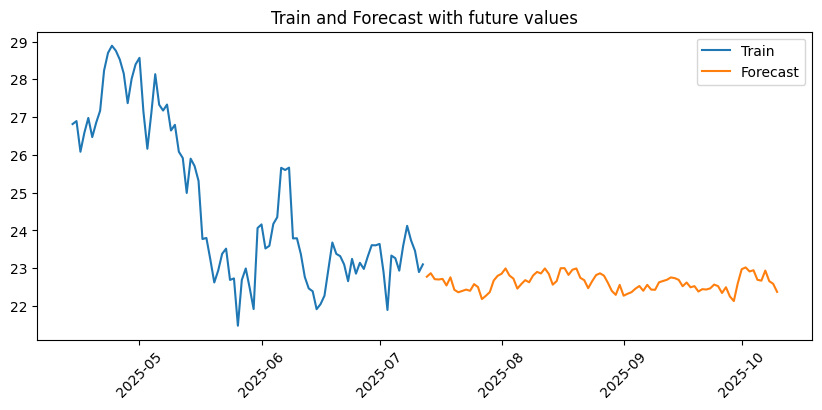

In [ ]:
plot_future(y_test,y_forecast_df,'future values')


In the end, we see that holt-winters method made better forecasting than other machine learning models like simple linear regression model and xgboost with multi output.

Why?
could be because linear regression couldn't capture the trend properly, while the xgboost